# Linear SVM

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import scipy.io as sio
%matplotlib inline

In [62]:
def load_data(path, X='X', y='y'):
    data = sio.loadmat(path)
    df = pd.DataFrame(data[X], columns=['X1', 'X2'])
    df['y'] = data[y]
    return df

In [63]:
df1 = load_data('data/ex6data1.mat')
df1.head()

,X1,X2,y
0,1.9643,4.5957,1
1,2.2753,3.8589,1
2,2.9781,4.5651,1
3,2.9320,3.5519,1
4,3.5772,2.8560,1


## Visualization

In [43]:
def plot_data(data):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(data['X1'], data['X2'], s=50, c = data['y'], cmap='Reds')
    ax.set_title('Raw data')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    plt.show()

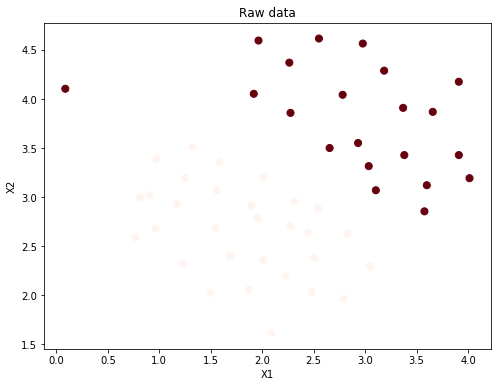

In [44]:
plot_data(df1)

## Try different C

In [50]:
def plot_svm(C, data):
    svc = svm.LinearSVC(C=C, loss='hinge', max_iter=1e4)
    svc.fit(data[['X1', 'X2']], data.y)
    score = svc.score(data[['X1', 'X2']], data.y)
    
    data[f"SVM{C} Confidence"] = svc.decision_function(data[['X1', 'X2']])
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(data.X1, data.X2, s=50, c=data[f"SVM{C} Confidence"], cmap='RdBu')
    ax.set_title(f"SVM C={C} Decision Confidence")
    plt.show()
    
    return score

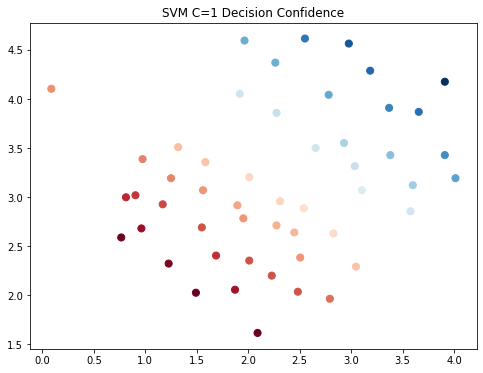

0.9803921568627451

In [51]:
plot_svm(1, df1)

C:\Users\Administrator\Anaconda3\envs\nlp\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


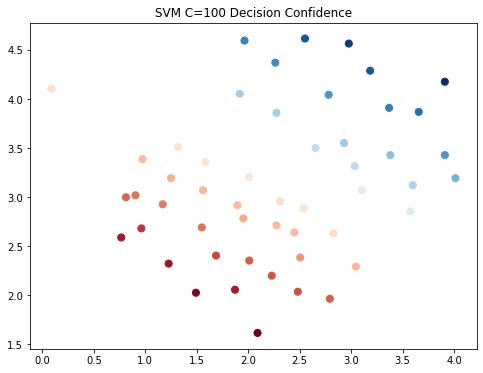

0.9803921568627451

In [48]:
plot_svm(100, df1)

In [40]:
df1.head()

,X1,X2,y,SVM1 Confidence,SVM100 Confidence
0,1.9643,4.5957,1,0.802826,4.404582
1,2.2753,3.8589,1,0.383916,2.202456
2,2.9781,4.5651,1,1.377494,6.275138
3,2.9320,3.5519,1,0.521182,2.318200
4,3.5772,2.8560,1,0.333432,0.927282


# Gaussian Kernel

In [33]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(-np.power(x1 - x2, 2).sum() / (2 * (sigma**2)))
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2
assert round(gaussian_kernel(x1, x2, sigma),3) == 0.325

In [41]:
df2 = load_data('data/ex6data2.mat')
df2.head(), df2.shape

(         X1        X2  y
 0  0.107143  0.603070  1
 1  0.093318  0.649854  1
 2  0.097926  0.705409  1
 3  0.155530  0.784357  1
 4  0.210829  0.866228  1, (863, 3))

## Visualization

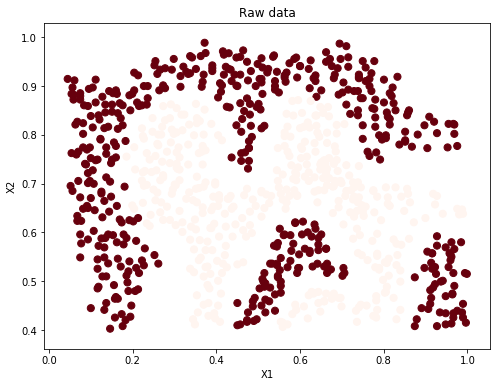

In [45]:
plot_data(df2)

## Try build-in Gaussian kernel of sklearn

In [54]:
svc = svm.SVC(C=100, kernel='rbf', gamma=10, probability=True)
svc.fit(df2[['X1', 'X2']], df2.y)
svc.score(df2[['X1', 'X2']], df2.y)

0.9698725376593279

In [57]:
predict_prob = svc.predict_proba(df2[['X1', 'X2']])[:, 0]

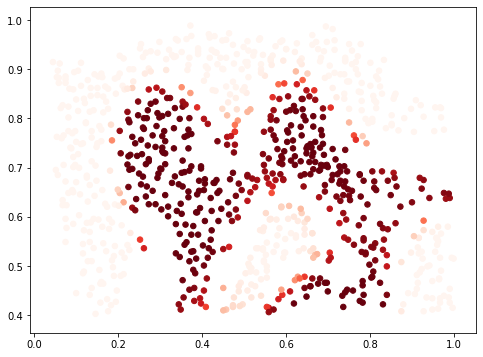

In [59]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(df2['X1'], df2['X2'], s=30, c=predict_prob, cmap='Reds')
plt.show()

# Find best params

## Manually

In [64]:
training = load_data('data/ex6data3.mat')
cv = load_data('data/ex6data3.mat', 'Xval', 'yval')

In [65]:
training.head(), training.shape

(         X1        X2  y
 0 -0.158986  0.423977  1
 1 -0.347926  0.470760  1
 2 -0.504608  0.353801  1
 3 -0.596774  0.114035  1
 4 -0.518433 -0.172515  1, (211, 3))

In [66]:
cv.head(), cv.shape

(         X1        X2  y
 0 -0.353062 -0.673902  0
 1 -0.227126  0.447320  1
 2  0.092898 -0.753524  0
 3  0.148243 -0.718473  0
 4 -0.001512  0.162928  0, (200, 3))

In [76]:
candidates = [.01, .03, .1, .3, 1, 3, 10, 30, 100]

In [77]:
combinations = [(C, gamma) for C in candidates for gamma in candidates]

In [81]:
results = []

for C, gamma in combinations:
    svc = svm.SVC(C=C, gamma=gamma)
    svc.fit(training[['X1', 'X2']], training.y)
    results.append(svc.score(cv[['X1', 'X2']], cv.y))
    
best_index = np.argmax(results)
best_score = max(results)
best_param = combinations[best_index]
best_score, best_param

(0.965, (0.3, 100))

In [84]:
best_svc = svm.SVC(C=.3, gamma=100)
best_svc.fit(training[['X1', 'X2']],training.y)
ypred = best_svc.predict(cv[['X1', 'X2']])

print(metrics.classification_report(cv.y, ypred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       113
           1       0.95      0.97      0.96        87

    accuracy                           0.96       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200



## sklearn GridSearchCV

In [91]:
parameters = {"C": candidates, "gamma": candidates}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, n_jobs=-1, cv=5)
clf.fit(training[['X1', 'X2']], training.y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
                         'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [93]:
clf.best_params_

{'C': 30, 'gamma': 3}

In [94]:
clf.best_score_

0.919431279620853

In [95]:
ypred = clf.predict(cv[['X1', 'X2']])
print(metrics.classification_report(ypred, cv.y))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       115
           1       0.93      0.95      0.94        85

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



It turns out that **GridSearch** will appropriate part of data as CV and use it to find the best candidate.  
So the reason for different result is just that GridSearch here is just using part of **training data** to train because it need part of data as cv set.

# Spam detection

In [102]:
df = sio.loadmat('data/spamTrain.mat')
X, y = df['X'], df['y'].ravel()
X.shape, y.shape

((4000, 1899), (4000,))

In [104]:
Xtest, ytest = sio.loadmat('data/spamTest.mat')['Xtest'], sio.loadmat('data/spamTest.mat')['ytest'].ravel()
Xtest.shape, ytest.shape

((1000, 1899), (1000,))

In [107]:
svc = svm.SVC(gamma='auto')
svc.fit(X, y)
pred = svc.predict(Xtest)
print(metrics.classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       692
           1       0.98      0.87      0.92       308

    accuracy                           0.95      1000
   macro avg       0.96      0.93      0.94      1000
weighted avg       0.95      0.95      0.95      1000



## Compared to Logistic Regression

In [110]:
logit = LogisticRegression(solver='lbfgs')
logit.fit(X, y)
pred = logit.predict(Xtest)
print(metrics.classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       692
           1       0.99      0.99      0.99       308

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



Turns out SVM's performance depands on what kind data was dealt with.

In this case, feature n is large(1899), so logistic regression or SVM without kernel(`linear kernel`) is a better choice.

In [112]:
svc = svm.SVC(gamma='auto', kernel='linear')
svc.fit(X, y)
pred = svc.predict(Xtest)
print(metrics.classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       692
           1       0.96      0.97      0.96       308

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000

